# Shoplifting Detection


In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, TimeDistributed, LSTM, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import Precision
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.layers import GlobalAveragePooling2D

import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from collections import Counter


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
def extract_frames(video_path, save_dir, num_frames=5):
    """Extract frames from video with better error handling"""
    if not os.path.exists(video_path):
        print(f"[ERROR] Video file not found: {video_path}")
        return
    
    os.makedirs(save_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"[ERROR] Cannot open video: {video_path}")
        return
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    if total_frames == 0:
        print(f"[ERROR] No frames found in video: {video_path}")
        cap.release()
        return

    if total_frames < num_frames:
        print(f"[WARN] {video_path} has only {total_frames} frames. Padding with duplicates.")
        frame_indices = list(range(total_frames)) + [total_frames - 1] * (num_frames - total_frames)
    else:
        frame_indices = np.linspace(0, total_frames - 1, num=num_frames, dtype=int)

    current_frame = 0
    saved = 0

    while cap.isOpened() and saved < num_frames:
        ret, frame = cap.read()
        if not ret:
            break

        if current_frame == frame_indices[saved]:
            filename = os.path.join(save_dir, f"frame_{saved:04d}.jpg")
            cv2.imwrite(filename, frame)
            saved += 1

        current_frame += 1

    cap.release()
    print(f"[INFO] Extracted {saved} frames from {video_path}")

In [4]:
def extract_frames_from_all_videos(video_dir, output_root, num_frames=5):
    """Extract frames from all videos in directory"""
    if not os.path.exists(video_dir):
        print(f"[ERROR] Video directory not found: {video_dir}")
        return
    
    os.makedirs(output_root, exist_ok=True)
    video_files = [f for f in os.listdir(video_dir) if f.lower().endswith(('.mp4', '.avi', '.mov', '.mkv'))]
    
    print(f"[INFO] Found {len(video_files)} video files in {video_dir}")
    
    for video_file in video_files:
        video_path = os.path.join(video_dir, video_file)
        video_name = os.path.splitext(video_file)[0]
        save_dir = os.path.join(output_root, video_name)
        
        extract_frames(video_path, save_dir, num_frames)

In [5]:
def load_video_frames(folder_path, target_size=(200, 200), num_frames=5):
    """Load and preprocess video frames - reduced size for memory efficiency"""
    if not os.path.exists(folder_path):
        print(f"[ERROR] Folder not found: {folder_path}")
        return None
    
    frame_files = sorted([
        f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png'))
    ])
    
    if len(frame_files) == 0:
        print(f"[WARN] No frame files found in {folder_path}")
        return None
    
    frames = []
    for file in frame_files[:num_frames]:
        img_path = os.path.join(folder_path, file)
        img = cv2.imread(img_path)
        if img is None:
            print(f"[WARN] Could not read image: {img_path}")
            continue
        img = cv2.resize(img, target_size)
        img = img.astype(np.float32) / 255.0
        frames.append(img)
    
    # Pad with black frames if fewer than expected
    while len(frames) < num_frames:
        frames.append(np.zeros((target_size[0], target_size[1], 3), dtype=np.float32))

    return np.stack(frames)  # shape: (num_frames, height, width, 3)

In [6]:
def build_dataset(dataset_path='Shop DataSet', num_frames=5):
    """Build dataset from extracted frames"""
    class_map = {
        'nonshoplifting_frames': 0,
        'shoplifting_frames': 1
    }
    
    X, y = [], []
    
    for class_folder, label in class_map.items():
        class_path = os.path.join(dataset_path, class_folder)
        
        if not os.path.exists(class_path):
            print(f"[ERROR] Class folder not found: {class_path}")
            continue
            
        print(f"[INFO] Processing {class_folder}...")
        
        video_folders = [f for f in os.listdir(class_path) if os.path.isdir(os.path.join(class_path, f))]
        
        for video_folder in video_folders:
            folder_path = os.path.join(class_path, video_folder)
            video_frames = load_video_frames(folder_path, num_frames=num_frames)
            
            if video_frames is not None:
                X.append(video_frames)
                y.append(label)
    
    print(f"[INFO] Loaded {len(X)} videos total")
    print(f"[INFO] Class distribution: {np.bincount(y)}")
    
    return np.array(X), np.array(y)

In [7]:
tf.keras.backend.clear_session()
gc.collect()
    
    # Set paths (adjust these to your actual paths)
shoplifting_dir = os.path.join(os.getcwd(), "Shop DataSet", 'shop lifters')
non_shoplifting_dir = os.path.join(os.getcwd(), "Shop DataSet", 'non shop lifters')
shoplifting_frames_dir = os.path.join(os.getcwd(), "Shop DataSet", 'shoplifting_frames')
non_shoplifting_frames_dir = os.path.join(os.getcwd(), "Shop DataSet", 'nonshoplifting_frames')
    
    # Extract frames (only run this once)
print("Extracting frames from videos...")
extract_frames_from_all_videos(shoplifting_dir, shoplifting_frames_dir, num_frames=5)
extract_frames_from_all_videos(non_shoplifting_dir, non_shoplifting_frames_dir, num_frames=5)

Extracting frames from videos...
[INFO] Found 324 video files in c:\Users\DELL\OneDrive - Alexandria National University\Desktop\cv\shoplifting detection\Shop DataSet\shop lifters
[INFO] Extracted 5 frames from c:\Users\DELL\OneDrive - Alexandria National University\Desktop\cv\shoplifting detection\Shop DataSet\shop lifters\shop_lifter_0.mp4
[INFO] Extracted 5 frames from c:\Users\DELL\OneDrive - Alexandria National University\Desktop\cv\shoplifting detection\Shop DataSet\shop lifters\shop_lifter_1.mp4
[INFO] Extracted 5 frames from c:\Users\DELL\OneDrive - Alexandria National University\Desktop\cv\shoplifting detection\Shop DataSet\shop lifters\shop_lifter_10.mp4
[INFO] Extracted 5 frames from c:\Users\DELL\OneDrive - Alexandria National University\Desktop\cv\shoplifting detection\Shop DataSet\shop lifters\shop_lifter_100.mp4
[INFO] Extracted 5 frames from c:\Users\DELL\OneDrive - Alexandria National University\Desktop\cv\shoplifting detection\Shop DataSet\shop lifters\shop_lifter_101

In [7]:
print("Loading dataset...")
X, y = build_dataset('Shop DataSet', num_frames=5)
    
if len(X) == 0:
        print("[ERROR] No data loaded! Check your paths and data.")
        exit()
    
print(f"Dataset shape: X={X.shape}, y={y.shape}")
    
    # Split data
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Loading dataset...
[INFO] Processing nonshoplifting_frames...
[INFO] Processing shoplifting_frames...
[INFO] Loaded 855 videos total
[INFO] Class distribution: [531 324]
Dataset shape: X=(855, 5, 200, 200, 3), y=(855,)
Training set: (684, 5, 200, 200, 3)
Test set: (171, 5, 200, 200, 3)


In [8]:
from tensorflow.keras.applications import MobileNetV2,InceptionV3,InceptionResNetV2,Xception,MobileNetV2,MobileNetV3Large,ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, TimeDistributed, GlobalAveragePooling2D, LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def create_improved_model(input_shape=(5, 200, 200, 3), fine_tune_at=150):
    # Load pretrained base model without top layers
    base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(200, 200, 3))
    base_model.trainable = True  
    
    # Freeze layers up to `fine_tune_at`
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # Define input
    inputs = Input(shape=input_shape)  # (batch, time_steps, height, width, channels)
    
    # TimeDistributed wrapper to apply CNN to each frame
    x = TimeDistributed(base_model)(inputs)
    x = TimeDistributed(GlobalAveragePooling2D())(x)

    # LSTM layers
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Bidirectional(LSTM(32))(x)

    # Fully connected layers
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    # Create model
    model = Model(inputs, outputs)

    # Compile
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [9]:
tf.keras.backend.clear_session()
gc.collect()
model = create_improved_model(input_shape=(5, 200, 200, 3), fine_tune_at=160)
model.summary()
    
    # Train model with callbacks
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3,min_lr=1e-5)  # Reduce learning rate on plateau
    ]
    
from sklearn.utils import class_weight
import numpy as np

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i : weights[i] for i in range(len(weights))}
print("Training model...")

X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)

history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=1, 
            validation_split=0.1,
            verbose=1,
            class_weight=class_weights
        )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 200, 200, 3)]  0         
                                                                 
 time_distributed (TimeDistr  (None, 5, 7, 7, 2048)    23564800  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 5, 2048)          0         
 tributed)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 5, 128)           1081856   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                        

In [10]:
def plot_training_history(history):
    """Plot training metrics"""
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [11]:
def evaluate_model(model, X_test, y_test):
    """Evaluate model and show metrics"""
    # Make predictions
    tf.keras.backend.clear_session()
    gc.collect()
    X_test = np.array(X_test, dtype=np.float32)
    y_test = np.array(y_test, dtype=np.float32)
    with tf.device('/CPU:0'):
        y_pred_probs = model.predict(X_test)
        y_pred = (y_pred_probs > 0.5).astype(int).ravel()  # Flatten predictions
    
    # Ensure y_test is flattened
    if len(y_test.shape) > 1 and y_test.shape[1] == 1:
        y_test = y_test.ravel()
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    labels = ['Non-Shoplifter', 'Shoplifter']
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=labels))
    
    return y_pred, y_pred_probs

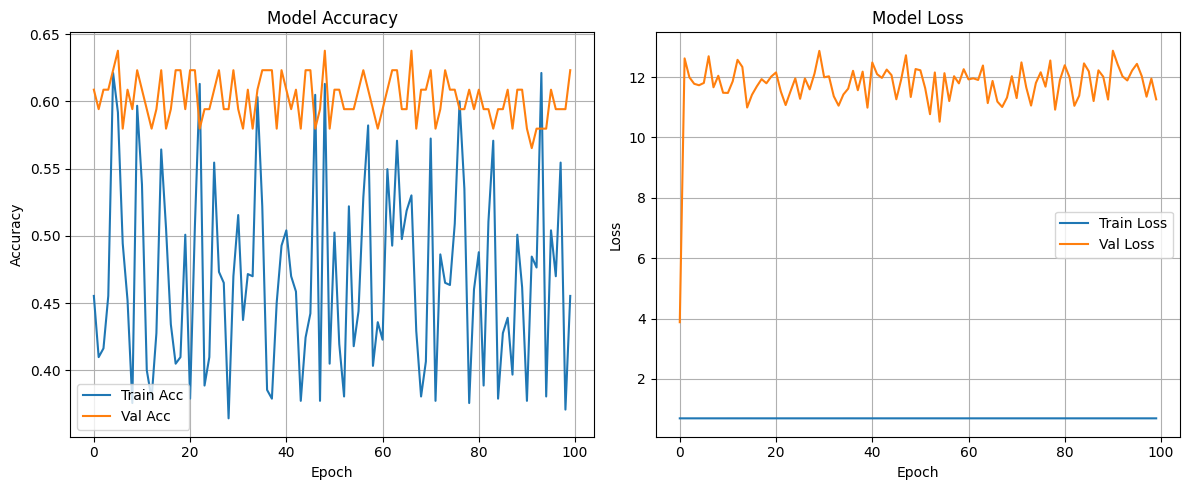

Evaluating model...
6/6 [==============================] - 54s 8s/step


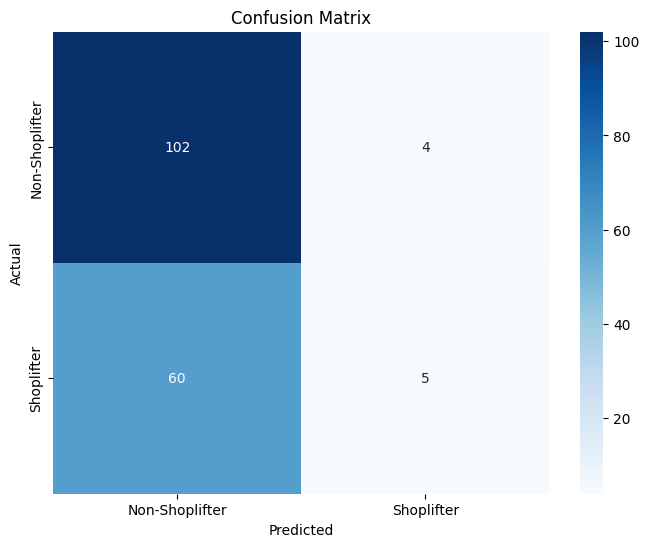

Classification Report:
                precision    recall  f1-score   support

Non-Shoplifter       0.63      0.96      0.76       106
    Shoplifter       0.56      0.08      0.14        65

      accuracy                           0.63       171
     macro avg       0.59      0.52      0.45       171
  weighted avg       0.60      0.63      0.52       171



In [12]:
plot_training_history(history)
    
    # Evaluate model
print("Evaluating model...")
y_pred, y_pred_probs = evaluate_model(model, X_test, y_test)